In [1]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

In [27]:
# Load storm event data (LBC results, for sewer subsection only)
# WRRF flow is in units of cubic feet/sec
# WRRF TSS load is in units of lb/sec
# WRRF TSS concentration is in units of mg/L
storm_nocontrol = np.load('../data/storm3.npy', allow_pickle=True)
storm_control = np.load('../data/storm3_control_both.npy', allow_pickle=True)

# 0 if saving no control results; 1 if saving control results
save = 1

if save == 0:
    storm = cp.deepcopy(storm_nocontrol)
    file_c = 'nc'
else:
    storm = cp.deepcopy(storm_control)
    file_c = 'c'

# File name for influent tsv
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm3_'+file_c+'_influent.tsv'

In [28]:
# Check storm event data contents
storm

array({'time': array([[28.],
       [28.],
       [28.],
       ...,
       [37.],
       [37.],
       [37.]], dtype=float16), 'WRRF_flow': array([[203.1602 ],
       [203.1596 ],
       [203.15903],
       ...,
       [201.13188],
       [201.1317 ],
       [201.13152]], dtype=float32), 'WRRF_TSSLoad': array([[2.0072799],
       [2.0073476],
       [2.0074155],
       ...,
       [1.9936501],
       [1.9937189],
       [1.9937873]], dtype=float32), 'WRRF_TSSConc': array([[158.22221791],
       [158.22802223],
       [158.23382655],
       ...,
       [158.73262017],
       [158.73824362],
       [158.74383419]]), 'WRRF_flow_dry': array([203.16020203, 203.15960693, 203.1590271 , ..., 201.78384399,
       201.78344727, 201.7830658 ]), 'WRRF_TSSLoad_dry': array([2.00727987, 2.00734758, 2.00741553, ..., 2.00311923, 2.00318694,
       2.00325465]), 'WRRF_flow_wet': array([ 0.        ,  0.        ,  0.        , ..., -0.65196228,
       -0.65174866, -0.65155029]), 'WRRF_TSSLoad_wet': array(

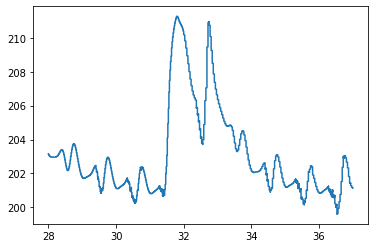

In [29]:
# Flow in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_flow'))

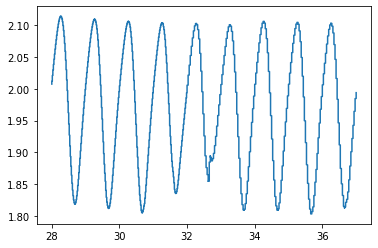

In [30]:
# TSS load in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSLoad'))

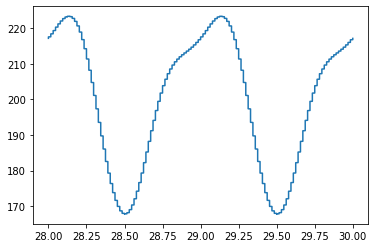

In [31]:
# Plot section that is dry-weather only
# Will average over this section to get dry-weather average value
dw_start = 0*24*60*60/10
dw_end = 2*24*60*60/10 #-1
plt.plot(storm_nocontrol.item().get('time')[int(dw_start):int(dw_end)],storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

seweroutflow = np.mean(storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

In [32]:
# Using ./data/flowPrecip.xlsx average dry-weather WRRF inflow is about 520.30 Mgal/d (1.9695 Mm3/d)
### OLD Average WRRF inflow is 2,788,860 m3/d
# Converting m3/d to cubic feet/sec ...
WRRFinflow = 1969500 * 35.3147 / 86400

In [33]:
# Ratio to scale from sewer subsection to GLWA WRRF influent
scale_ratio = WRRFinflow/seweroutflow
scale_ratio

4.021934198773301

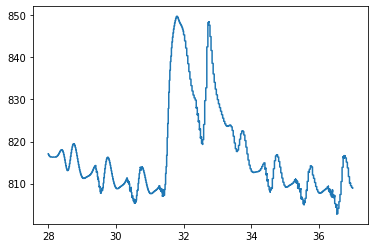

In [34]:
# Flow for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_flow'))

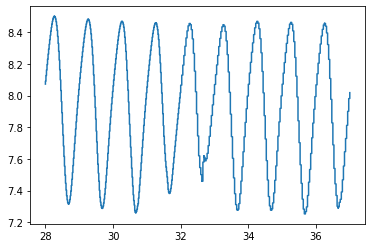

In [35]:
# TSS load for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_TSSLoad'))

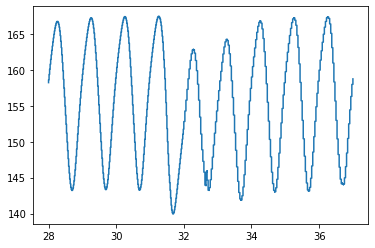

In [36]:
# TSS concentration for GLWA WRRF influent (same as that for sewer subsection since concentration)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSConc'))

In [37]:
# Using GLWA WRRF model, ...
# influent TP is 2.2 mg P/L, 
# fraction of PO4 in total phosphorus is 53.3%, so influent SP is 1.1726 mg P/L, 
# influent PP (particular phosphorus) is 1.0274 mg P/L

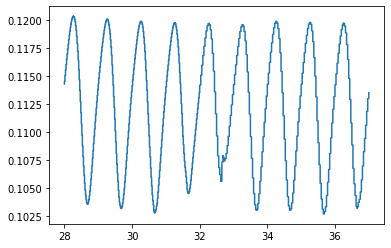

In [38]:
# For current simplification, phosphorus will only include total phosphorus without fractionation
# and will mirror TSS dynamics

# TP concentration in mg/L
WRRF_TPConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 2.2

# TP load in lb/sec for GLWA WRRF influent
WRRF_TPLoad = np.multiply(WRRF_TPConc,scale_ratio*storm.item().get('WRRF_flow')) * 2.205 / (10**6) * 28.32

# TP load for GLWA WRRF influent
plt.plot(storm.item().get('time'),WRRF_TPLoad)

In [39]:
storm_df = pd.DataFrame(data=np.column_stack((storm.item().get('time'),
                                        scale_ratio*storm.item().get('WRRF_flow'),
                                        scale_ratio*storm.item().get('WRRF_TSSLoad'),
                                        storm.item().get('WRRF_TSSConc'),
                                        WRRF_TPLoad,
                                        WRRF_TPConc)),
                  columns=['time',
                           'WRRF_flow',
                           'WRRF_TSSLoad',
                           'WRRF_TSSConc',
                           'WRRF_TPLoad',
                           'WRRF_TPConc'])
storm_df

,time,WRRF_flow,WRRF_TSSLoad,WRRF_TSSConc,WRRF_TPLoad,WRRF_TPConc
0,28.0,817.096924,8.073147,158.222218,0.114292,2.239967
1,28.0,817.094543,8.073420,158.228022,0.114296,2.240049
2,28.0,817.092224,8.073693,158.233827,0.114300,2.240131
3,28.0,817.089844,8.073965,158.239614,0.114304,2.240213
4,28.0,817.087524,8.074240,158.245435,0.114308,2.240296
...,...,...,...,...,...,...
77755,37.0,808.940552,8.017776,158.721390,0.113508,2.247034
77756,37.0,808.939880,8.018053,158.727013,0.113512,2.247114
77757,37.0,808.939148,8.018329,158.732620,0.113516,2.247193
77758,37.0,808.938416,8.018606,158.738244,0.113520,2.247273


In [40]:
with open(w_influentTSV,'w') as write_tsv:
    write_tsv.write(storm_df.to_csv(sep='\t', index=False))